## Import Library

In [3]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflowjs
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.applications import mobilenet_v2, ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow import keras
import numpy as np
import uuid
import time
import pathlib
import warnings
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import imghdr

In [4]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## LOAD DATASETS

In [6]:
# Setting Up Datasets
batch_size = 16
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/tmp/training_ind/food_datasets',
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/tmp/valid_ind/validation',
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3000 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.
['Bakso', 'Gado', 'Rendang', 'Sate']


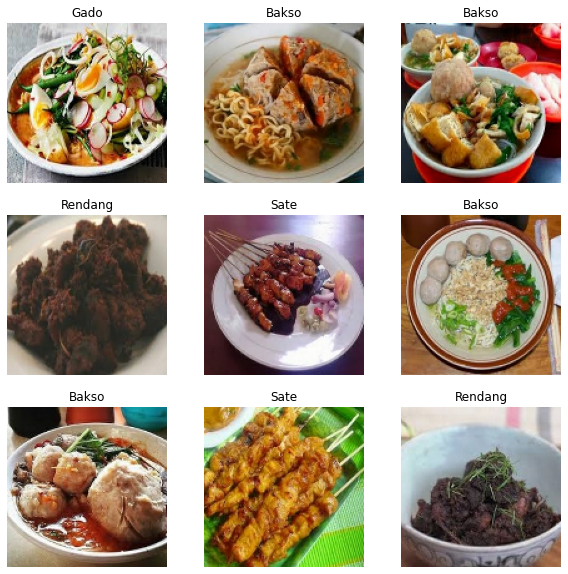

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Image Augmentation

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9980372


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
  ]
)

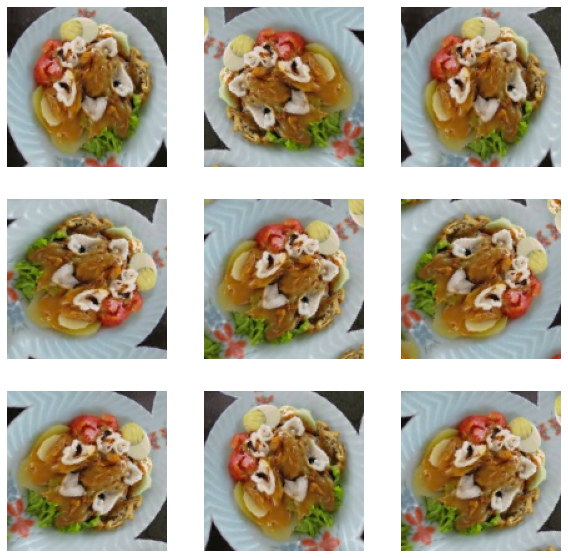

In [11]:
# To See What The Dataset Looklike
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Modelling

In [12]:
# Setting Up Checkpoint
# Keeping Highest Accuracy and Weight
checkpoint = ModelCheckpoint(filepath='./tmp/checkpoint', monitor="val_accuracy", mode="max",save_best_only=True, save_weights_only=True)

# Setting Up Callbacks
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 95 and logs.get('val_accuracy') > 0.93: # @KEEP
                print("\nReached 90% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True


In [13]:
# Adding Layers
model = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4)
])

In [14]:
# Setting Up Optimizer and Loss also adding the callback function into the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
callbacks = [myCallback(),checkpoint]
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)     

In [15]:
history = model.fit(
              train_ds,
              validation_data=val_ds,
              # steps_per_epoch = 10000 // 32,
              epochs = 150,
              verbose = 1,
              callbacks=[callbacks]
            )

Epoch 1/150
188/188 [==============================] - 75s 260ms/step - loss: 1.0507 - accuracy: 0.6107 - val_loss: 1.0029 - val_accuracy: 0.58106s - loss: 1.9822 - accuracy: 0. - ETA: 32s - loss: 1.9876 - accuracy: 0. - ETA: 29s - loss: 2.0712 - accuracy: 0 - ETA: 26s - loss: 1.9471 - accuracy: - ETA: 23s - loss: 1.7879 - accuracy: 0.46 - ETA: 22s - loss: 1.7367 - accu - ETA: 19s - loss: 1.5996 - accuracy: 0.49 - ETA: 18s - loss: 1.5810 - accuracy: 0.495 - ETA: 18s - loss: 1.5689 - accuracy: 0. - ETA: 17s - loss: 1.5369 - accuracy: 0 - ETA: 16s - loss: 1.4897 - accuracy: 0.51 - ETA: 16s - loss: 1.4701 - accuracy: 0 - ETA: 15s - loss: 1.4198 - accuracy:  - ETA: 14s - loss: 1.3840 - accuracy: - ETA: 13s - loss: 1.3458 - accuracy: 0.547 - ETA: 12s - loss: 1.3380 - accuracy: 0. - ETA: 12s - loss: 1.3162 - accuracy: 0. - ETA: 11s - loss: 1.3006 - accuracy: 0. - ETA: 11s - loss: 1.2774 - accuracy:  - ETA: 10s - loss: 1.2549  - ETA: 8s - loss: 1.2179 
Epoch 2/150
188/188 [===================

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(150)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_path = '/tmp/test/sate6.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
tfjs.converters.save_keras_model(model, '/Users/e203a/temp/Bangkit/PROJECTS')